# distilGPT2 Fine-Tuning v2

In [1]:
import torch
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

ver = 2

## Load Data

In [51]:
import pandas as pd
data = pd.read_csv('../out.csv')
data

,Unnamed: 0,lastfm_url,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,mbid,spotify_id,genre,Lyric,language
0,1,https://www.last.fm/music/metallica/_/st.%2banger,St. Anger,Metallica,['aggressive'],8,3.710000,5.833000,5.427250,727a2529-7ee8-4860-aef6-7959884895cb,3fOc9x06lKJBhz435mInlH,metal,Saint Anger 'round my neck\nSaint Anger 'round...,en
1,3,https://www.last.fm/music/m.i.a./_/bamboo%2bbanga,Bamboo Banga,M.I.A.,"['aggressive', 'fun', 'sexy', 'energetic']",13,6.555071,5.537214,5.691357,99dd2c8c-e7c1-413e-8ea4-4497a00ffa18,6tqFC1DIOphJkCwrjVzPmg,hip-hop,"Road runner, road runner\nGoing hundred mile p...",en
2,5,https://www.last.fm/music/drowning%2bpool/_/st...,Step Up,Drowning Pool,['aggressive'],9,2.971389,5.537500,4.726389,49e7b4d2-3772-4301-ba25-3cc46ceb342e,4Q1w4Ryyi8KNxxaFlOQClK,metal,Come!\n\nIf our own lives aren’t directly affe...,en
3,11,https://www.last.fm/music/kanye%2bwest/_/feedback,Feedback,Kanye West,['aggressive'],1,3.080000,5.870000,5.490000,NaN,49fT6owWuknekShh9utsjv,hip-hop,"Ayy, y'all heard about the good news?\nY'all s...",en
4,13,https://www.last.fm/music/deftones/_/7%2bwords,7 Words,Deftones,"['aggressive', 'angry']",10,3.807121,5.473939,4.729091,1a826083-5585-445f-a708-415dc90aa050,6DoXuH326aAYEN8CnlLmhP,nu metal,"I'll never be the same, breaking decency\nDon'...",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792,229432,https://www.last.fm/music/noblegases/_/xenon,Xenon,NobleGases,['noble'],2,6.160000,3.695000,6.130000,NaN,1AePjgLLtzF0abbfcgYdLI,chill,You're floating out astray\nThis cold and life...,en
16793,229435,https://www.last.fm/music/kurt%2bvile/_/wild%2...,Wild Imagination,Kurt Vile,['transparent'],2,6.925000,4.975000,6.190000,NaN,1Gn0oYQiQHp7KF4DcR2g4t,NaN,I'm looking at you\nBut It's only a picture so...,en
16794,229436,https://www.last.fm/music/portugal.%2bthe%2bma...,Oh Lord,Portugal. The Man,['transparent'],1,5.370000,3.450000,5.330000,7ea228f9-16d0-474d-8c51-5a1a9810ddde,6YG8cjbrjhDhlYMiQnibUD,indie,\n\n\nWhere do I fit in\nI am waiting here for...,en
16795,229443,https://www.last.fm/music/porcelain%2band%2bth...,Transparent,Porcelain and The Tramps,['transparent'],3,6.613333,4.633333,5.773333,NaN,NaN,industrial,Wish I were transparent\nYou could see right t...,en


## Load Model & Tokenizer

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [4]:
model = AutoModelForCausalLM.from_pretrained('distilgpt2')  # Use this to load default distilgpt2

In [3]:
model = AutoModelForCausalLM.from_pretrained(f'./v{ver}_final_model')  # Use this to load our fine tuned model

## Preprocess Tags

Need to run this

In [6]:
data['seeds'] = data['seeds'].apply(lambda i: eval(i))

## Preprocess Lyrics

In [7]:
chunk_size = 128
buffer = 8
question = 'What are the moods evoked by the following song excerpt?'

def text_repr(lyrics: str, tags: list) -> list[str]:
    tags = tags[:10]  # Trim the number of tags to prevent some errors
    extra_tokens = len(tokenizer(f'Q: {question}\n\nA: {", ".join(tags)}{tokenizer.eos_token}')['input_ids'])
    this_chunk_size = chunk_size - extra_tokens
    all_tokens = tokenizer(lyrics)['input_ids']
    chunks = [all_tokens[i:i + this_chunk_size] for i in range(0, len(all_tokens), this_chunk_size)]
    chunks = [f'Q: {question}\n{tokenizer.decode(i)}\nA: {", ".join(tags)}{tokenizer.eos_token}' for i in chunks]
    chunks = tokenizer(chunks, padding=True, truncation=True, max_length=chunk_size + buffer)['input_ids']
    return chunks[:-1]  # Remove last element to avoid misaligned sequences

This code creates a training dataset with all lyrics + tags.

In [8]:
prompts = data['Lyric']
tags = data['seeds']

tokenized_data_expanded = [text_repr(prompts.iloc[i], tags.iloc[i]) for i in tqdm(range(len(prompts)))]
tokenized_data = []
for i in tokenized_data_expanded:
    tokenized_data += i

  0%|          | 0/16797 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1083 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
tokenized_data = [i for i in tokenized_data if len(i) == chunk_size]  # Remove any data which still isn't the right size

## Build Dataset

In [12]:
!pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.7/28.7 MB 22.0 MB/s eta 0:00:0000:0100:01
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


In [14]:
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(tokenized_data, test_size=.1)

In [11]:
print(tokenizer.decode(x_train[0]))

NameError: name 'x_train' is not defined

## Train Model

No need to do this since fine tuning is already complete.

In [44]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [45]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=f"distilgpt2-finetuned-v{ver}",
    save_total_limit=10,
    evaluation_strategy="epoch",
    # evaluation_strategy="steps",
    # eval_steps=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=15
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=x_train,
    eval_dataset=x_val,
    data_collator=data_collator,
)

trainer.train()

NameError: name 'x_train' is not defined

In [46]:
trainer.save_model(f'v{ver}_final_model')  # DO NOT RUN THIS

NameError: name 'trainer' is not defined

## Evaluation

In [4]:
from transformers import pipeline
text_generator = pipeline('text-generation', tokenizer=tokenizer, model=model)

In [5]:
chunk_size = 128
buffer = 8
question = 'What are the moods evoked by the following song excerpt?'

def process_lyrics(lyrics: str) -> list[str]:
    extra_tokens = len(tokenizer(f'Q: {question}\n\nA: ')['input_ids'])
    this_chunk_size = chunk_size - extra_tokens
    all_tokens = tokenizer(lyrics)['input_ids']
    chunks = [all_tokens[i:i + this_chunk_size] for i in range(0, len(all_tokens), this_chunk_size)]
    chunks = [f'Q: {question}\n{tokenizer.decode(i)}\nA: ' for i in chunks]
    chunks = tokenizer(chunks, padding=False, truncation=True, max_length=chunk_size + buffer)['input_ids']
    return chunks  # Remove last element to avoid misaligned sequences

In [162]:
LYRICS = """
[Intro: Cardi B, Al "T" McLaran & Megan Thee Stallion]
Whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house (Hol' up)
I said certified freak, seven days a week
Wet-ass pussy, make that pullout game weak, woo (Ah)

[Chorus: Cardi B]
Yeah, yeah, yeah, yeah
Yeah, you fuckin' with some wet-ass pussy
Bring a bucket and a mop for this wet-ass pussy
Give me everything you got for this wet-ass pussy
[Verse 1: Cardi B & Megan Thee Stallion]
Beat it up, nigga, catch a charge
Extra large and extra hard
Put this pussy right in your face
Swipe your nose like a credit card
Hop on top, I wanna ride
I do a kegel while it's inside
Spit in my mouth, look in my eyes
This pussy is wet, come take a dive
Tie me up like I'm surprised
Let's roleplay, I'll wear a disguise
I want you to park that big Mack truck right in this little garage
Make it cream, make me scream
Out in public, make a scene
I don't cook, I don't clean
But let me tell you how I got this ring (Ayy, ayy)

[Verse 2: Megan Thee Stallion]
Gobble me, swallow me, drip down the side of me (Yeah)
Quick, jump out 'fore you let it get inside of me (Yeah)
I tell him where to put it, never tell him where I'm 'bout to be (Huh)
I'll run down on him 'fore I have a nigga runnin' me (Pow, pow, pow)
Talk your shit, bite your lip (Yeah)
Ask for a car while you ride that dick (While you ride that dick)
You really ain't never gotta fuck him for a thang (Yeah)
He already made his mind up 'fore he came (Ayy, ah)
Now get your boots and your coat for this wet-ass pussy (Ah, ah, ah)
He bought a phone just for pictures of this wet-ass pussy (Click, click, click)
Paid my tuition just to kiss me on this wet-ass pussy (Mwah, mwah, mwah)
Now make it rain if you wanna see some wet-ass pussy (Yeah, yeah)
[Verse 3: Cardi B & Megan Thee Stallion]
Look, I need a hard hitter, need a deep stroker
Need a Henny drinker, need a weed smoker
Not a garter snake, I need a king cobra
With a hook in it, hope it lean over
He got some money, then that's where I'm headed
Pussy A1 just like his credit
He got a beard, well, I'm tryna wet it
I let him taste it, now he diabetic
I don't wanna spit, I wanna gulp
I wanna gag, I wanna choke
I want you to touch that lil' dangly thing that swing in the back of my throat
My head game is fire, punani Dasani
It's goin' in dry and it's comin' out soggy
I ride on that thing like the cops is behind me (Yeah, ah)
I spit on his mic and now he tryna sign me, woo

[Verse 4: Megan Thee Stallion]
Your honor, I'm a freak bitch, handcuffs, leashes
Switch my wig, make him feel like he cheatin'
Put him on his knees, give him somethin' to believe in
Never lost a fight, but I'm lookin' for a beatin' (Ah)
In the food chain, I'm the one that eat ya
If he ate my ass, he's a bottom-feeder
Big D stand for big demeanor
I could make ya bust before I ever meet ya
If it don't hang, then he can't bang
You can't hurt my feelings, but I like pain
If he fuck me and ask "Whose is it?"
When I ride the dick, I'ma spell my name, ah
[Chorus: Cardi B]
Yeah, yeah, yeah
Yeah, you fuckin' with some wet-ass pussy
Bring a bucket and a mop for this wet-ass pussy
Give me everything you got for this wet-ass pussy
Now from the top, make it drop, that's some wet-ass pussy
Now get a bucket and a mop, that's some wet-ass pussy
I'm talkin' wap, wap, wap, that's some wet-ass pussy
Macaroni in a pot, that's some wet-ass pussy, huh

[Outro: Al "T" McLaran]
There's some whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house
There's some whores in this house
"""

In [88]:
processed_lyrics_chunks = process_lyrics(LYRICS)
len(processed_lyrics_chunks)

8

In [89]:
idx = 1
print(text_generator(tokenizer.decode(processed_lyrics_chunks[idx]), 
                     max_length=len(processed_lyrics_chunks[idx]) + 10)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: What are the moods evoked by the following song excerpt?
 the ho'in'
Make that money rain as they taking off they clothes
Order plane tickets
Cali is the mission
Visit every month like I'm split life living
Let the world listen
If a hater's caught slipping
Then my niggas stay tight
Got my back like Pippen
Fast life gripping
Yeah, we still tippin'
Codeine cups paint a picture so vivid
Fakes try to mimic
Get girls timid
But behind closed doors they get poles so rigid

A: iced, light, sweet, quiet, soft,


1. function to analyze an entire song
    - collate tags from all excerpts
    - rank tags
    - select some number of best tags as output
2. function to evaluate model's performance on a single song
    - inputs: model's generated text, correct tags from dataset ground truth
    - output: numerical score indicating how well the model performed (ideally 0-1)
    - could factor in multiple runs per song?
3. apply function to all songs in dataset and plot scores

In [158]:
BLACKLIST = [
    'ive',
    'ersatz',
    'ery',
    'e',
    'no',
    'ado',
    'tri',
    'ute',
    'ric',
    '"',
    'ious',
    'izzy',
    'su'
]

In [93]:
PAD_TOKEN = tokenizer(tokenizer.pad_token)['input_ids'][0]

from spellchecker import SpellChecker
spell = SpellChecker()
def check(word: str) -> bool:
    if word == spell.correction(word) and word not in BLACKLIST:
        return True
    else:
        return False

def flatten_array(array):
    tags_array = []
    for i in array:
        tags_array += i
    return tags_array
    
def tags_for_excerpt(tokens: list) -> str:
    # tokens = tokenizer(excerpt)['input_ids']
    excerpt = tokenizer.decode(tokens)
    output = text_generator(excerpt, 
                         max_length=len(tokens) + 10)[0]['generated_text']
    response = output[output.rfind('A: ') + 3:]
    response_tags = response.split(', ')
    response_tags = [i.strip(', \nÂ') for i in response_tags]
    response_tags = list(filter(check, response_tags))
    return response_tags

import numpy as np
def format_tags(tags, num):
    unique_tags, counts = np.unique(tags, return_counts=True)
    sorted_tags = unique_tags[np.argsort(counts)][::-1]
    return list(sorted_tags[:num])

def format_lyrics(lyrics):
    lyrics_lst = lyrics.split("\n")
    result = [[lyrics_lst[0], 1]]

    for i in range(len(lyrics_lst) - 1):
        if lyrics_lst[i] != lyrics_lst[i+1] or lyrics_lst[i+1] == '':
            result.append([lyrics_lst[i+1], 1])
        else:
            result[-1][1] += 1

    result2 = [i[0] for i in result]
    for i in range(len(result)):
        if result[i][1] > 1:
            result2[i] += f" (x{result[i][1]})"
    return '\n'.join(result2)

def gen_tags(lyrics: str, num_tags: int) -> list[list[str]]:
    lyrics = format_lyrics(lyrics)
    chunks = process_lyrics(lyrics)
    result = [tags_for_excerpt(i) for i in chunks]
    
    tags_array = flatten_array(result)
    
    return format_tags(tags_array, num_tags)

def process_user(lyrics_arr):
    return format_tags(flatten_array(map(lambda i: gen_tags(i, 8), lyrics_arr)), 10)


tags = process_user([LYRICS])
tags
#print(format_lyrics(LYRICS))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['wistful',
 'poignant',
 'grim',
 'energetic',
 'driving',
 'demonic',
 'calm',
 'bright']

Let's say we make a function song_analysis_pipeline(song_lyrics, num_tags_to_select).

For each dataset element:

- Lyrics
- Correct tags

Count correct tags, results = song_analysis_pipeline(Lyrics, len(correct_tags)).

score = number of tags in results which are also in correct_tags / total number of correct tags

## Result Frequency Analysis

In [96]:
evaluation = data.sample(1000)
evaluation

,Unnamed: 0,lastfm_url,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,mbid,spotify_id,genre,Lyric,language
3867,41457,https://www.last.fm/music/television/_/mars,Mars,Television,"['nocturnal', 'stylish']",2,5.485000,3.875000,5.840000,fd2a2781-b663-412b-97ca-8814d7471cd5,4aD0RFy4Y6i8eToTXdizZZ,rock,The new millennium is here\nThe smell of napal...,en
10360,124742,https://www.last.fm/music/minnie%2briperton/_/...,Lovin' You,Minnie Riperton,['romantic'],15,7.479298,4.762456,6.267632,7878c8d1-baa3-4df5-a259-bfd677406308,4twhYPDyCP6ICeW3TtQVxP,soul,If you've been wonderin' what I'm gonna do\nWh...,en
11531,139475,https://www.last.fm/music/tiesto%2bfeat%2bblue...,No More Heroes,Tiesto feat Blue Man Group,['complex'],2,4.896667,4.200000,3.870000,NaN,NaN,trance,Took a shot in the dark\nThough the aim was tr...,en
12017,150169,https://www.last.fm/music/fairport%2bconventio...,Eastern Rain,Fairport Convention,"['sophisticated', 'wistful']",3,3.936000,2.150000,4.036000,7d298a78-e11c-4a3f-8494-cd3eaa9ab4f3,6pKkm4Nm195wamPdBDOze6,folk,Rain comes from the east one night\nWe watch i...,en
2102,20692,https://www.last.fm/music/the%2bcure/_/disinte...,Disintegration,The Cure,"['dark', 'melancholy', 'sad']",13,4.627320,3.914948,4.409588,a32db75a-7d8b-40ef-a05e-b1ac6a318b8b,0zY8t5dC1KQXcPUKByWMJM,new wave,Oh I miss the kiss of treachery\nThe shameless...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,60372,https://www.last.fm/music/front%2bline%2bassem...,The State,Front Line Assembly,"['meditative', 'spiritual']",4,3.358000,2.528000,3.070000,2dfcd993-2380-4898-81bb-1b411d3076df,4Xtrz1TSmZFtkjqqfeR0v6,industrial,"Oh, The State cut off my arms and the state to...",en
11926,147946,https://www.last.fm/music/pete%2band%2bthe%2bp...,Bears,Pete and the Pirates,['serious'],1,5.880000,4.050000,5.670000,NaN,3XTxZ3Znz0uMpdVbFeSPmA,rock,Some folks say there ain't no bears in Arkansa...,en
1044,8341,https://www.last.fm/music/madonna/_/keep%2bthe...,Keep The Trance,Madonna,['fierce'],2,6.913333,6.113333,6.593333,NaN,NaN,electronic,Hey you!\nDon't give up\nEither good or bad\nT...,en
10329,124015,https://www.last.fm/music/billy%2bjoel/_/she%2...,She's Always a Woman,Billy Joel,"['romantic', 'mellow']",18,6.153978,3.777312,5.728495,506ae263-7f46-47b7-9e83-055505cfb279,5RgFlk1fcClZd0Y4SGYhqH,piano,She can kill with a smile\nShe can wound with ...,en


In [98]:
tags = evaluation['Lyric'].progress_apply(lambda i: gen_tags(i, 100))

  0%|          | 0/1000 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

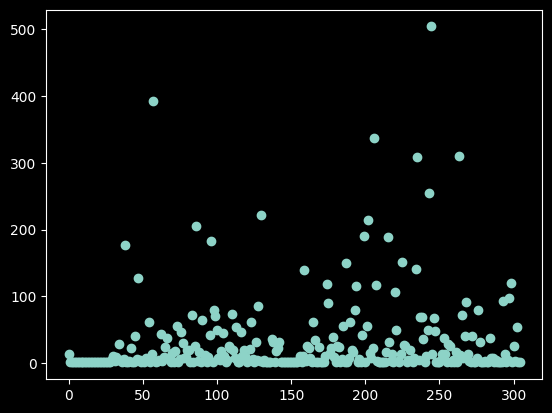

In [108]:
all_tags = np.concatenate(list(tags))
unique_tags, counts = np.unique(all_tags, return_counts=True)
plt.scatter(np.arange(counts.shape[0]), counts)
plt.show()

In [113]:
floor_tags, floor_counts = unique_tags[counts > 5], counts[counts > 5]
average_freqs = floor_counts / 1000
sort = np.argsort(floor_counts)
tags_weighted = floor_tags[sort]
tags_weighted

array(['no', 'ado', 'crunchy', 'philosophical', 'apocalyptic', 'harsh',
       'bitters', 'clinical', 'tense', 'brash', 'tri', 'urgent',
       'ominous', 'sens', 'lonely', 'cold', 'euphoric', 'defiant',
       'provocative', 'ute', 'freewheeling', 'celebratory', 'airy',
       'delicate', 'naive', 'elaborate', 'lazy', 'gloomy', 'meditative',
       'exuberant', 'sleazy', 'joyous', 'gritty', 'aggressive',
       'technical', 'eerie', 'sacred', 'brooding', 'thrilling', 'ric',
       'somber', 'sparse', 'spooky', 'whimsical', '"', 'comic',
       'menacing', 'precious', 'refined', 'earnest', 'paranoid',
       'summery', 'complex', 'exciting', 'introspective', 'grim',
       'flowing', 'detached', 'scary', 'desperate', 'organic',
       'halloween', 'pure', 'fiery', 'ious', 'mysterious', 'lively',
       'autumnal', 'cerebral', 'manic', 'negative', 'stylish',
       'narrative', 'dreamy', 'literate', 'wry', 'sardonic', 'fierce',
       'sarcastic', 'angry', 'strong', 'dark', 'humorous', 

In [132]:
# Had to update blacklist
blacklist_mask = [i not in BLACKLIST for i in floor_tags]
tags_no_blacklist, freqs_no_blacklist = floor_tags[blacklist_mask], average_freqs[blacklist_mask]
sort = np.argsort(freqs_no_blacklist)
tags_weighted = tags_no_blacklist[sort]
freqs_sorted = freqs_no_blacklist[sort]
tags_weighted

array(['philosophical', 'apocalyptic', 'bitters', 'crunchy', 'harsh',
       'lonely', 'urgent', 'tense', 'brash', 'sens', 'ominous',
       'clinical', 'provocative', 'freewheeling', 'defiant', 'cold',
       'euphoric', 'celebratory', 'naive', 'airy', 'elaborate',
       'delicate', 'exuberant', 'sleazy', 'gloomy', 'meditative', 'lazy',
       'aggressive', 'gritty', 'joyous', 'technical', 'eerie', 'sacred',
       'thrilling', 'brooding', 'whimsical', 'somber', 'spooky', 'sparse',
       'precious', 'comic', 'menacing', 'refined', 'earnest', 'summery',
       'paranoid', 'introspective', 'complex', 'exciting', 'scary',
       'grim', 'desperate', 'flowing', 'detached', 'organic', 'halloween',
       'pure', 'mysterious', 'fiery', 'lively', 'autumnal', 'negative',
       'manic', 'cerebral', 'dreamy', 'sardonic', 'narrative', 'stylish',
       'literate', 'wry', 'fierce', 'sarcastic', 'angry', 'strong',
       'dark', 'humorous', 'relaxed', 'intimate', 'triumphant', 'ironic',
       

In [133]:
freqs_sorted

array([0.006, 0.006, 0.006, 0.006, 0.006, 0.007, 0.007, 0.007, 0.007,
       0.007, 0.007, 0.007, 0.008, 0.008, 0.008, 0.008, 0.008, 0.009,
       0.009, 0.009, 0.009, 0.009, 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.011, 0.011, 0.011, 0.012, 0.012, 0.013, 0.013, 0.013, 0.014,
       0.014, 0.014, 0.014, 0.015, 0.015, 0.015, 0.016, 0.016, 0.017,
       0.017, 0.018, 0.018, 0.018, 0.019, 0.019, 0.019, 0.019, 0.019,
       0.02 , 0.021, 0.022, 0.022, 0.022, 0.023, 0.023, 0.024, 0.024,
       0.024, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.032, 0.032, 0.032, 0.035,
       0.036, 0.036, 0.037, 0.037, 0.038, 0.039, 0.04 , 0.04 , 0.041,
       0.042, 0.042, 0.043, 0.045, 0.046, 0.046, 0.048, 0.049, 0.05 ,
       0.05 , 0.054, 0.054, 0.055, 0.056, 0.056, 0.062, 0.062, 0.062,
       0.062, 0.064, 0.067, 0.069, 0.069, 0.07 , 0.072, 0.072, 0.074,
       0.079, 0.079, 0.08 , 0.085, 0.09 , 0.092, 0.093, 0.098, 0.106,
       0.115, 0.117,

In [137]:
tag_map = {tags_weighted[i]: freqs_sorted[i] for i in range(len(tags_weighted))}

import pickle
with open('tag_map.data', 'wb') as f:
    pickle.dump(tag_map, f)

In [139]:
import pickle
with open('tag_map.data', 'rb') as f:
    tag_map = pickle.load(f)

In [167]:
UNK_TAG_WEIGHT = 0
TOKENS_TO_GENERATE = 10

In [169]:
PAD_TOKEN = tokenizer(tokenizer.pad_token)['input_ids'][0]

from spellchecker import SpellChecker
spell = SpellChecker()
def check(word: str) -> bool:
    if word == spell.correction(word) and word not in BLACKLIST:
        return True
    else:
        return False

def flatten_array(array: list):
    tags_array = []
    for i in array:
        tags_array += i
    return tags_array
    
def tags_for_excerpt(tokens: list) -> str:
    # tokens = tokenizer(excerpt)['input_ids']
    excerpt = tokenizer.decode(tokens)
    output = text_generator(excerpt, 
                         max_length=len(tokens) + TOKENS_TO_GENERATE)[0]['generated_text']
    response = output[output.rfind('A: ') + 3:]
    response_tags = response.split(', ')
    response_tags = [i.strip(', \nÂ') for i in response_tags]
    response_tags = list(filter(check, response_tags))
    return response_tags

import numpy as np
def select_tags(tags: list, num: int):
    unique_tags, counts = np.unique(tags, return_counts=True)
    
    freq_diffs = []
    for i in range(len(unique_tags)):
        if unique_tags[i] in tag_map.keys():
            freq_diffs.append(counts[i] / len(tags) - tag_map[unique_tags[i]])
        else:
            freq_diffs.append(UNK_TAG_WEIGHT)
    sorted_tags = unique_tags[np.argsort(freq_diffs)][::-1]
    return list(sorted_tags[:num])

def format_lyrics(lyrics):
    lyrics_lst = lyrics.split("\n")
    result = [[lyrics_lst[0], 1]]

    for i in range(len(lyrics_lst) - 1):
        if lyrics_lst[i] != lyrics_lst[i+1] or lyrics_lst[i+1] == '':
            result.append([lyrics_lst[i+1], 1])
        else:
            result[-1][1] += 1

    result2 = [i[0] for i in result]
    for i in range(len(result)):
        if result[i][1] > 1:
            result2[i] += f" (x{result[i][1]})"
    return '\n'.join(result2)

def gen_tags(lyrics: str, num_tags: int) -> list[list[str]]:
    lyrics = format_lyrics(lyrics)
    chunks = process_lyrics(lyrics)
    result = [tags_for_excerpt(i) for i in chunks]
    
    tags_array = flatten_array(result)
    
    return select_tags(tags_array, num_tags)

def process_user(lyrics_arr):
    return select_tags(flatten_array(map(lambda i: gen_tags(i, 8), lyrics_arr)), 10)


tags = process_user([LYRICS])
tags
#print(format_lyrics(LYRICS))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['flowing',
 'rousing',
 'nocturnal',
 'positive',
 'confident',
 'sexual',
 'dramatic',
 'warm']